In [2]:
pip install spotipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
df = pd.DataFrame({"name": ['Alfred', 'Batman', 'Catwoman'],
                   "toy": [np.nan, 'Batmobile', 'Bullwhip'],
                   "born": [pd.NaT, pd.Timestamp("1940-04-25"),
                            pd.NaT]})

In [3]:
# general imports
import math
import re
import csv
import os
import json
import pickle
import random
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# spotify api imports
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

# network building imports
import networkx as nx
from community import community_louvain
import fa2

We are using a subset of the #nowplaying dataset. The #nowplaying dataset includes tracks which have been tweeted using the hashtags #nowplaying, #listento or #listeningto.

The dataset which we are going to use holds users, their playlists and the tracks contained in these playlists. Our interest is just in the tracks; what a particular user is listening to. Therefore, the playlistname column will be removed.

In [4]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# load in the dataset
path = '/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.csv'
spotify_df = pd.read_csv(path, 
                         skiprows=1,
                         names=['user_id', 'artistname', 'trackname', 'playlistname'],
                         on_bad_lines='skip')

# drop any null values
spotify_df = spotify_df.dropna()
print("Initial dataset size:", len(spotify_df))
spotify_df.head()

Initial dataset size: 12867130


,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


The `artistname` column contains the artist’s name extracted from the tweets with minimal pre-processing. Therefore, we should validate the column by checking if the values correspond to a single or multiple artists since a song can be performed by a single artist, multiple artists, or groups. 

We start with computing a set with all values of the `artistname`.

In [21]:
# generate initial artists set
artists_set = set(map(lambda artist: str(artist).lower(), spotify_df.artistname))
len(artists_set)

282520

The dataset contains 282520 unique values for the `artistname`. Now, we want to check how many of these values correspond to a single artist or collaborations.

One problem with the dataset is how the names of artists who collaborated on the same song are delimited. Since there is no standard delimitation, we split the `artistname` using multiple delimiters: "&", ",",  "/", "and", "feat.", "ft.", "featuring", "with" and check if it is a true collaboration and not the name of an artistic group. This isn't perfect, but we try to separate out as many artists as possible.

In short, if there was a collaboration, we split the artist names into individual elements of a list. If it wasn't a collaboration, we simply return the original artist.

In [22]:
def get_true_artists():
  i = 0
  for idx, entry in spotify_df.iterrows():
    # check the progress of the function
    if i % 100000 == 0:
        print(i, "/", len(spotify_df))
    i += 1

    names = re.split('( and | & |, | \/ | feat. | feat | ft. | f. | featuring | with | - |; )', str(entry.artistname).lower())
    # check if it is a collaboration:
    if (set(names) & (artists_set)):
        # update the entry
        entry.artistname = list((set(names) & (artists_set)))
    else:
        entry.artistname = [str(entry.artistname).lower()]

In [23]:
get_true_artists()

0 / 12867130
100000 / 12867130
200000 / 12867130
300000 / 12867130
400000 / 12867130
500000 / 12867130
600000 / 12867130
700000 / 12867130
800000 / 12867130
900000 / 12867130
1000000 / 12867130
1100000 / 12867130
1200000 / 12867130
1300000 / 12867130
1400000 / 12867130
1500000 / 12867130
1600000 / 12867130
1700000 / 12867130
1800000 / 12867130
1900000 / 12867130
2000000 / 12867130
2100000 / 12867130
2200000 / 12867130
2300000 / 12867130
2400000 / 12867130
2500000 / 12867130
2600000 / 12867130
2700000 / 12867130
2800000 / 12867130
2900000 / 12867130
3000000 / 12867130
3100000 / 12867130
3200000 / 12867130
3300000 / 12867130
3400000 / 12867130
3500000 / 12867130
3600000 / 12867130
3700000 / 12867130
3800000 / 12867130
3900000 / 12867130
4000000 / 12867130
4100000 / 12867130
4200000 / 12867130
4300000 / 12867130
4400000 / 12867130
4500000 / 12867130
4600000 / 12867130
4700000 / 12867130
4800000 / 12867130
4900000 / 12867130
5000000 / 12867130
5100000 / 12867130
5200000 / 12867130
5300000 

Pickle this new dataframe

In [28]:
spotify_df.to_pickle(r'/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

Examine the new dataframe

In [7]:
spotify_df = pd.read_pickle('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

In [8]:
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,[tiffany page],7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Alison,HARD ROCK 2010


Now, we should have lesser artists because we got rid of some artist names that were essentially extensions of an artist.

Eg. 'Elvis Costello' and 'Elvis Costello and the Attractions' are both now Elvis Costello.

In [13]:
# update artists set; this is the new set of artists after doing some pre-processing to obtain each unique artist
artists_set = set([artist for artists in spotify_df.artistname for artist in artists])
len(artists_set)

241267

We want to know the popularity of each artist, based on the user sample. We compute the popularity as frequency of artist appearing over all the rows.

In [14]:
# compute number of occurrences
popularity = Counter(x for xs in spotify_df.artistname for x in set(xs))
popularity.most_common(5)

[('daft punk', 36309),
 ('coldplay', 35626),
 ('radiohead', 31467),
 ('the rolling stones', 30826),
 ('kanye west', 30035)]

Display popularity distribution

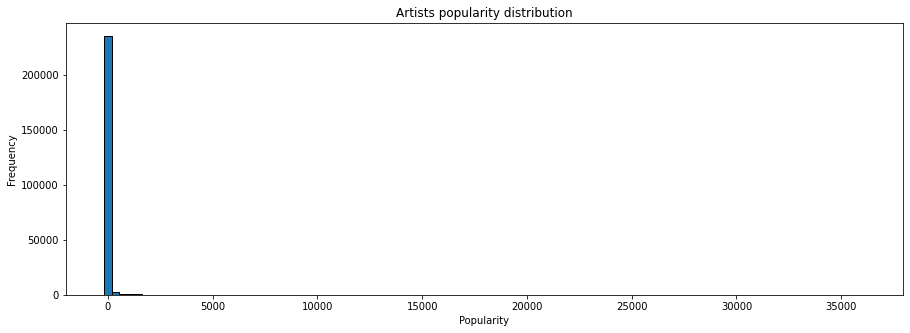

In [15]:
values = list(popularity.values())
# return an array with histogram values and the bin edges 
hist, bin = np.histogram(values, bins=100)

plt.figure(figsize=(15, 5))
plt.title('Artists popularity distribution')
plt.bar(bin[:-1], hist, width=bin[1]-bin[0], ec='k', lw=1)
plt.xlabel("Popularity")
plt.ylabel("Frequency")

plt.show()

We notice that the distribution is tail-heavy, ie. there are a lot of artists that don't appear very frequently in the dataset. To counteract this skewness, we have opted to remove artists that appear in the dataset 50 times or less.

In [16]:
# update artists set; this is the new set of artists that occur more than 50 times in the dataset
artists_set = set([key for key, val in popularity.items() if val > 50])

In [19]:
remove_idx = []
i = 0
for idx, entry in spotify_df.iterrows():
    # check the progress of the function
    if i % 100000 == 0:
        print(i, "/", len(spotify_df))
    i += 1
    if not set(entry.artistname).issubset(artists_set):
        remove_idx.append(idx)

0 / 12867130
100000 / 12867130
200000 / 12867130
300000 / 12867130
400000 / 12867130
500000 / 12867130
600000 / 12867130
700000 / 12867130
800000 / 12867130
900000 / 12867130
1000000 / 12867130
1100000 / 12867130
1200000 / 12867130
1300000 / 12867130
1400000 / 12867130
1500000 / 12867130
1600000 / 12867130
1700000 / 12867130
1800000 / 12867130
1900000 / 12867130
2000000 / 12867130
2100000 / 12867130
2200000 / 12867130
2300000 / 12867130
2400000 / 12867130
2500000 / 12867130
2600000 / 12867130
2700000 / 12867130
2800000 / 12867130
2900000 / 12867130
3000000 / 12867130
3100000 / 12867130
3200000 / 12867130
3300000 / 12867130
3400000 / 12867130
3500000 / 12867130
3600000 / 12867130
3700000 / 12867130
3800000 / 12867130
3900000 / 12867130
4000000 / 12867130
4100000 / 12867130
4200000 / 12867130
4300000 / 12867130
4400000 / 12867130
4500000 / 12867130
4600000 / 12867130
4700000 / 12867130
4800000 / 12867130
4900000 / 12867130
5000000 / 12867130
5100000 / 12867130
5200000 / 12867130
5300000 

In [ ]:
spotify_df.drop(remove_idx, axis=0, inplace=True)

In [31]:
len(spotify_df)

11445393

In [32]:
# examine the first 5 rows
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Alison,HARD ROCK 2010
5,9cc0cfd4d7d7885102480dd99e7a90d6,[lissie],All Be Okay,HARD ROCK 2010


We now pickle this dataframe so in future runs of the notebook, we can simply load this in.

In [44]:
spotify_df.to_pickle(r'/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

## Create Spotify Artist Network 
based off collaborations found from subset of #nowplaying dataset

In [49]:
# load in the pickled dataframe
spotify_df = pd.read_pickle('/content/drive/MyDrive/University Materials/Business Analytics/Y3S1/02805 Social graphs & interactions/Data/Spotify Network/spotify_dataset.pickle') 

In [50]:
# examine the first 5 rows
spotify_df.head()

,user_id,artistname,trackname,playlistname
0,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,[elvis costello],Alison,HARD ROCK 2010
5,9cc0cfd4d7d7885102480dd99e7a90d6,[lissie],All Be Okay,HARD ROCK 2010


In [54]:
artists_set = set([artist for artists in spotify_df.artistname for artist in artists])

23682

In [51]:
len(artists_set)

23682

In [ ]:
import networkx as nx
# construct artist network
artists_graph = nx.Graph()
artists_graph.add_nodes_from(artists_set)

We extract the collaborations from the spotify dataset, where we have a collaboration only if there are multiple entries in the list of artists associated with each track.

In [ ]:
collaborations = spotify_df.loc[map(lambda artists: len(artists) > 1, spotify_df.artistname)]
len(collaborations)

Each artist is connected by their collaborations.

In [ ]:
i = 0
for _, entry in collaborations.iterrows():
    # check progress of the function
    if i % 100000 == 0:
        print(i, "/", len(collaborations))
    i+=1
    for a in range(len(entry.artistname) - 1):
        for b in range(a+1, len(entry.artistname)):
            artists_graph.add_edge(list(entry.artistname)[a], list(entry.artistname)[b])

## Spotify Artist Network
Now that we have created the initial network of artists connected via their collaborations, we do further pre-processing of the graph.

We decided to:
- Remove the isolated nodes (artists without collaborations)
- Extract the largest component and use it as our artist network

In [ ]:
artists_graph.remove_nodes_from(list(nx.isolates(artists_graph)))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("number of nodes:", artists_graph.number_of_nodes())
print("number of edges:", artists_graph.number_of_edges())

## Getting additional information from Spotify API about each song
In this section, we get more information about each artist. Namely, we obtain the Spotify ID (which can be used to check if the artist is on Spotify), popularity, genres and related artists.

We remove the artists that are not found on Spotify (by the ID).

In [ ]:
artists_set = set(artists_graph.nodes())
data = {'artistname': list(artists_set),
        'id': [None] * len(artists_set),
        'popularity': [None] * len(artists_set),
        'genres': [None] * len(artists_set),
        'related_artists': [None] * len(artists_set)}
artists_df = pd.DataFrame(data)

In [ ]:
# load credentials
credentials = json.load(open('authorization.json'))
client_id = credentials['client_id']
client_secret = credentials['client_secret']

In [ ]:
def search_artist_spotify(artist):
    results = sp.search(q=artist.artistname, type='artist')

    for result in results['artists']['items']:
        # check if artist was found
        if result['name'].lower() == artist.artistname:
            artist.id = result["id"]
            artist.popularity = result["popularity"]
            artist.genres = result["genres"]
    
    return artist

In [ ]:
def get_related_artists_spotify(artist):
    results = sp.artist_related_artists(artist.id)

    related_artists=list()
    for result in results['artists']:
        if result['name'].lower() in set(artists_df.artistname):
            related_artists.append(result['name'].lower())
    artist.related_artists = related_artists

In [ ]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ))

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        print(i, "/", len(artists_df))
    i += 1
    artist = search_artist_spotify(artist)

In [ ]:
sp = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret,
    ), requests_timeout=10, retries=10)

i = 0
for _, artist in artists_df.iterrows():
    if i % 100 == 0:
        # os.system('clear')
        clear_output()
        print(i, "/", len(artists_df))
    i += 1
    if artist.id != None:
        get_related_artists_spotify(artist)

In [ ]:
# these are the artists that are not on Spotify
no_info = (list(artists_df[artists_df.id.isnull()].artistname) + list(artists_df[artists_df.genres.isnull()].artistname))

In [ ]:
# remove the nodes (artists) that are not on Spotify
artists_graph = nx.Graph(artists_graph) # unfreeze the graph
artists_graph.remove_nodes_from(list(no_info))
Gcc = sorted(nx.connected_components(artists_graph), key=len, reverse=True)
artists_graph = artists_graph.subgraph(Gcc[0])

print("number of nodes:", artists_graph.number_of_nodes())
print("number of edges:", artists_graph.number_of_edges())

Plot the network

In [ ]:
nx.draw(artists_graph, node_size=list(dict(artists_graph.degree()).values()))

Degree distribution

In [ ]:
# Plot degree distribution
degree = list(dict(artists_graph.degree()).values())
hist, bin = np.histogram(degree, bins=range(min(degree), max(degree))) # return an array with histogram values and the bin edges 

# f, ax = plt.subplots(1,2, figsize=(15,5))
plt.title('Degree distribution')
plt.bar(bin[:-1], hist)
plt.xlabel("Degree")
plt.ylabel("Frequency")

plt.show()

Check if distribution obeys a power law

In [ ]:
from math import exp
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
import powerlaw

degree_sequence = sorted(list(dict(artists_graph.degree()).values()), reverse=True)
alpha_in = powerlaw.Fit(degree_sequence).alpha
print("The slope of the incoming degree distribution", alpha_in)
degree_freq = Counter(degree_sequence)

x = np.log(np.array(list(degree_freq.keys())))
y = np.log(np.array(list(degree_freq.values())))

ymin, ymax = ([0, y.max()])
ymid = (ymin + ymax) / 2
xmin, xmax = ([0, x.max()])
xmid = (xmin + xmax) / 2

y1 = -alpha_in * (xmin - xmid) + ymid
y2 = -alpha_in * (xmax - xmid) + ymid

fig = plt.figure()
ax = plt.gca()
plt.scatter(degree_freq.keys(), degree_freq.values() , alpha=0.65)
ax.plot(np.exp([xmin, xmax]), np.exp([y1, y2]), 'r', label="alpha_in")

plt.title("in-degree distribution")
plt.xlabel('Degree')
plt.ylabel('Frequency')
plt.loglog()
plt.legend()

Find the modularity of the best paritition, and inspect the communities

In [ ]:
from community import community_louvain
# compute the best partition
communities = community_louvain.best_partition(artists_graph, random_state=0) 
# we used random_state parameter so that the results can be reproduced
mod = community_louvain.modularity(communities, artists_graph)
print("modularity is", mod)

no_communities = len(Counter(communities.values()))
print("The Louvain algorithm had found", no_communities, "communities")

for community, count in Counter(communities.values()).most_common():
    print("The community", community, "has", count, "nodes")

## Plot the network
- We color the different communities differently to show the modularity of the network.
- We also display each node differently depending on the degree of each node.

In [ ]:
forceatlas2 = fa2.ForceAtlas2(
                        # Behavior alternatives
                        outboundAttractionDistribution=False,  # Dissuade hubs
                        edgeWeightInfluence=0,

                        # Performance
                        jitterTolerance=0.9,  # Tolerance
                        barnesHutOptimize=True,
                        barnesHutTheta=1.2,

                        # Tuning
                        scalingRatio=0.1,
                        strongGravityMode=True,
                        gravity=0.6,

                        # Log
                        verbose=True)
positions = forceatlas2.forceatlas2_networkx_layout(artists_graph, pos=None, iterations=2000)
        
plt.figure(figsize=(12, 10), dpi=80)
communities_color = {} # keep a dict with colors for each community
nodelist_dc = []

for community in  Counter(communities.values()):
    communities_color[community] = np.array([random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1)])
    nodelist = []
    
    for node in artists_graph:
        if node not in communities:
            nodelist_dc.append(node)
        elif communities[node] == community:
            nodelist.append(node)
    # display nodes from current Marvel's community       
    nx.draw_networkx_nodes(artists_graph,
                           pos=positions,
                           nodelist=nodelist,
                           node_size=list(dict(artists_graph.degree(nodelist)).values()),
                           node_color=communities_color[community].reshape(1,-1), label=community)
nx.draw_networkx_edges(artists_graph, pos=positions, alpha=0.05)
plt.legend()